### 1. cloud mask

The cloud mask is used to remove clouds in the image, which have a different atmoshperic condition compared to the object on the ground. I use a binary dialation to expand out mask to remove most of the cloud, also.

In [1]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
%matplotlib inline
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
%matplotlib inline

In [31]:
cl = classification(fhead = 'data/50SMG20165100', bands = (2,3,4,8,11,12,13), bounds = None)

In [32]:
cl.Get_cm_p()

get some imgs
data/50SMG20165100 (2, 3, 4, 8, 11, 12, 13)
process 1...
process 2...data/50SMG20165100auxiliaryECMWFT
data/50SMG20165100metadata.xml

process 3...
process 4...
process 5...
process 6...
process 7...
process 8...
process 9...
process 10...
process 11...
process 12...
process 13...
process 14...


In [34]:
parallel_rw_pkl(cl.cp, '0510cp', 'w')
del cl

In [35]:
cp = parallel_rw_pkl(None, '0510cp', 'r')

In [ ]:
plt.imshow(cl.cm[::10,::10])

In [ ]:
parallel_rw_pkl(cl.cm, '0510cm', 'w')

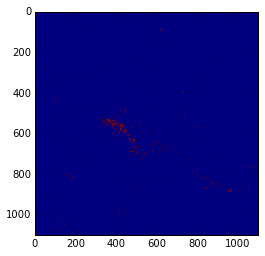

In [24]:
mask = parallel_rw_pkl(None, '0510cm', 'r')
plt.imshow(mask[::10,::10])

In [3]:
b4 = readfile([4,], 'data/50SMG20165100')

data/50SMG20165100auxiliaryECMWFT
data/50SMG20165100metadata.xml


In [25]:
struct1 = ndimage.generate_binary_structure(2, 1)
mask = bd(mask, structure=struct1, iterations=4).astype(mask.dtype)

<matplotlib.colorbar.Colorbar instance at 0x7fdf5cf637a0>

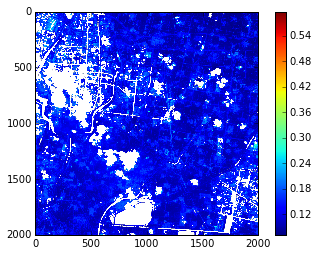

In [52]:
data = b4['B04']
plt.imshow(ma.array(data, mask=b)[5000:7000,4000:6000])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fdf8db077a0>

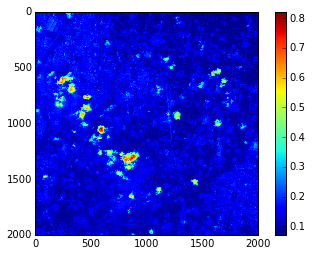

In [27]:
plt.imshow(data[5000:7000,4000:6000])
plt.colorbar()

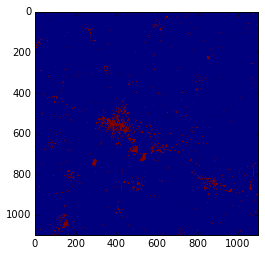

In [49]:
m = cp>0# a combination of all posible cloud mask to maximumly remove those cloud pixels
b = (m|mask)
plt.imshow(b[::10,::10])

<matplotlib.colorbar.Colorbar instance at 0x7fdf5dd332d8>

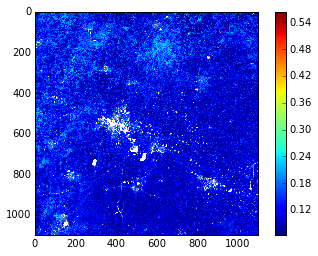

In [51]:
plt.imshow(ma.array(data, mask=b)[::10,::10])
plt.colorbar()

In [54]:
parallel_rw_pkl(b, '0510diacm', 'w')# stored as a cloud mask can be used for later usage

### Simple average though those pixles that within the coverage of a modis pixlel

In [ ]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl

fhead = 'data/50SMG20165100'

def shift(process):
    store = []
    for i, j in process:
        print i,j

        s1 = slice((i*1000),(i+1)*1000)
        s2 = slice((j*1000),(j+1)*1000)
        modis_cut = modis_sent[s1,s2]*0.001
        Stm_cut = Stm[s1,s2]

        sen_cut = Sent[s1,s2]
        ulist = np.unique(Stm_cut)
        
        
        for ii,u in enumerate(ulist):
            mask = (Stm_cut == u)
            if (mask.sum() >= 1800) and (mask.sum() < 4000):
                xmin = np.where(mask)[0].min()
                xmax = np.where(mask)[0].max()
                ymin = np.where(mask)[1].min()
                ymax = np.where(mask)[1].max()
                center = np.array([(xmax+xmin)/2, (ymax+ymin)/2])
                center0 = np.array([(xmax+xmin)/2, (ymax+ymin)/2])
                center1 = np.array([49, 112])
                offset = center0 - center1
                x = inds[1] + offset[0]
                y = inds[0] + offset[1]
                cmask = (x>=0)&(y>=0)&(x<1000)&(y<1000)
                sx,sy = x[cmask], y[cmask]
                if (len(sx)>0) & (len(sy)>0):
                    mean = np.nanmean(sen_cut[sx, sy])
                    brdf = modis_cut[center[0],center[1]]
                    store.append([mean, brdf])
                    print ii,u,mean, brdf
                else:
                    pass
            else:
                pass
    return store

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

ind = pkl.load(open('pkls/gaus_trans.pkl','rb'))
inds = ind
data = parallel_rw_pkl(None, 'inter_sent%i'%0, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%0, 'r')
Sent = readfile([2,],fhead)['B02']
stm = parallel_rw_pkl(None, 'std_m', 'r')
print 'finshed reading data'
data[mask]=np.nan
modis_sent = np.array(data)
Stm = stm
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
pros = np.array(np.array_split(patches, 16))

par = partial(shift)
pool = multiprocessing.Pool(processes=16)
#data = pool.map(par, pros)
pool.close()
pool.join()
parallel_rw_pkl(data, 'b2_modis', 'w')

print 'lol finishedb2!!!!!'    

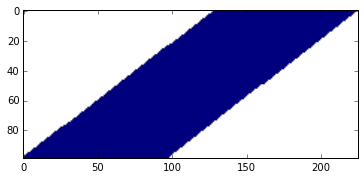

In [2]:
ind = pkl.load(open('pkls/gaus_trans.pkl','rb'))
a = np.zeros((99, 225))
a[:] = np.nan
a[ind[1], ind[0]] = 1
plt.imshow(a)

Above is a typical area that covered by modis pixel geo-transformed to the sentinel projection, and this is the area that the mean value from and also the gaussian spread function based on for the later gaussian convolution.

In [90]:
b4_modis = parallel_rw_pkl(None, 'b4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'b2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'b3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'b8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'b8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'b11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'b12_modis', 'r')

In [91]:
bands = []
for j in [b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    data = []
    for i in j:
        data+=i
    bands.append(data)
names = ('b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis').split(',')

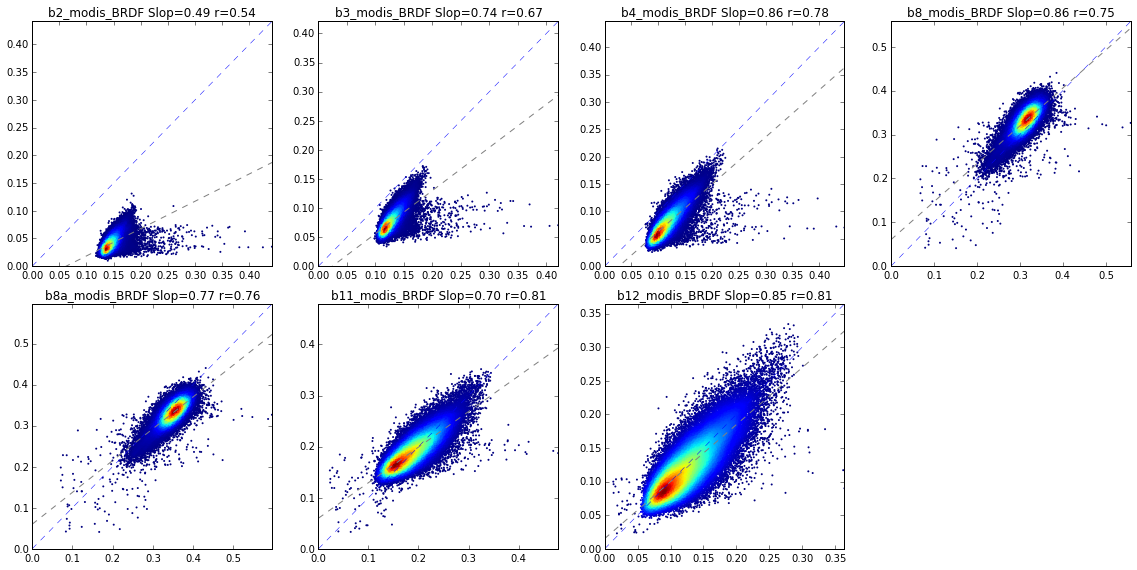

In [92]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~np.isnan(data[:,1])]
    s = data[:,1][~np.isnan(data[:,1])]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s_BRDF'%names[i]+' Slop=%.2f'%r.slope+' r=%.2f'%r.rvalue)
plt.tight_layout()

The cloud mask can be used to refine the results, as the cloud has a totally different atmospheric condition compared to the ground objects.

In [ ]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl

fhead = 'data/50SMG20165100'

def shift(process):
    store = []
    for i, j in process:
        print i,j

        s1 = slice((i*1000),(i+1)*1000)
        s2 = slice((j*1000),(j+1)*1000)
        modis_cut = modis_sent[s1,s2]*0.001
        Stm_cut = Stm[s1,s2]

        sen_cut = Sent[s1,s2]
        ulist = np.unique(Stm_cut)
        
        
        for ii,u in enumerate(ulist):
            mask = (Stm_cut == u)
            if (mask.sum() >= 1800) and (mask.sum() < 4000):
                xmin = np.where(mask)[0].min()
                xmax = np.where(mask)[0].max()
                ymin = np.where(mask)[1].min()
                ymax = np.where(mask)[1].max()
                center = np.array([(xmax+xmin)/2, (ymax+ymin)/2])
                center0 = np.array([(xmax+xmin)/2, (ymax+ymin)/2])
                center1 = np.array([49, 112])
                offset = center0 - center1
                x = inds[1] + offset[0]
                y = inds[0] + offset[1]
                cmask = (x>=0)&(y>=0)&(x<1000)&(y<1000)
                sx,sy = x[cmask], y[cmask]
                if (len(sx)>0) & (len(sy)>0):
                    mean = np.nanmean(sen_cut[sx, sy])
                    brdf = modis_cut[center[0],center[1]]
                    store.append([mean, brdf])
                    print ii,u,mean, brdf
                else:
                    pass
            else:
                pass
    return store

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

ind = pkl.load(open('pkls/gaus_trans.pkl','rb'))
inds = ind
data = parallel_rw_pkl(None, 'inter_sent%i'%0, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%0, 'r')
Sent = readfile([2,],fhead)['B02']
cm = parallel_rw_pkl(None, '0510diacm', 'r')
Sent[cm] = np.nan
stm = parallel_rw_pkl(None, 'std_m', 'r')
print 'finshed reading data'
data[mask]=np.nan
modis_sent = np.array(data)
Stm = stm
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
pros = np.array(np.array_split(patches, 16))

par = partial(shift)
pool = multiprocessing.Pool(processes=16)
#data = pool.map(par, pros)
pool.close()
pool.join()
parallel_rw_pkl(data, 'b2_modis', 'w')

print 'lol finishedb2!!!!!'    

In [177]:
b4_modis = parallel_rw_pkl(None, 'cmb4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'cmb2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'cmb3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'cmb8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'cmb8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'cmb11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'cm12_modis', 'r')

In [178]:
bands = []
for j in [b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    data = []
    for i in j:
        data+=i
    bands.append(data)    

In [179]:
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')

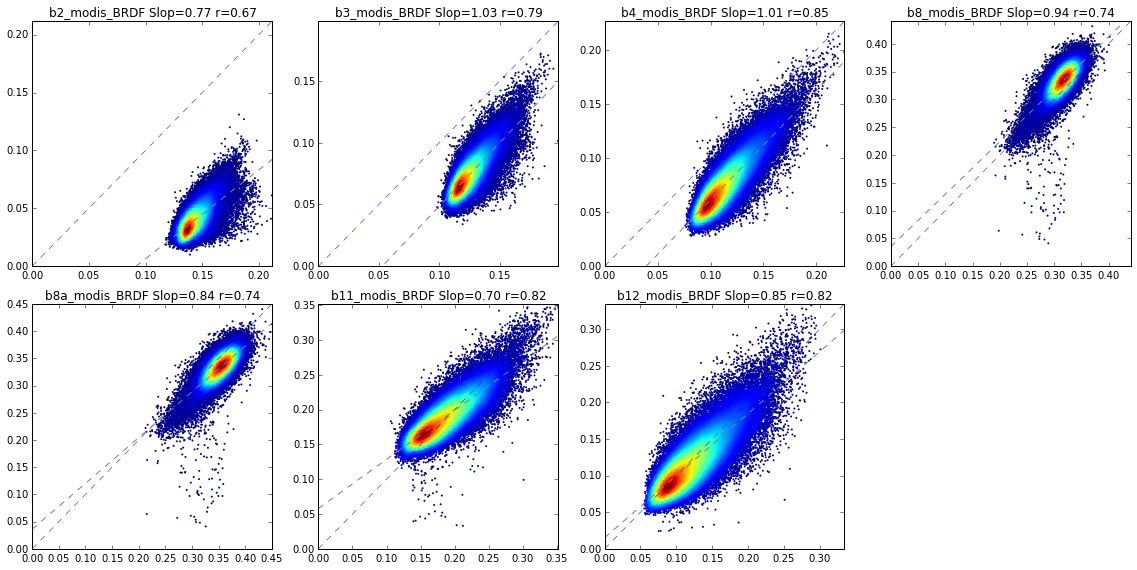

In [298]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' Slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()

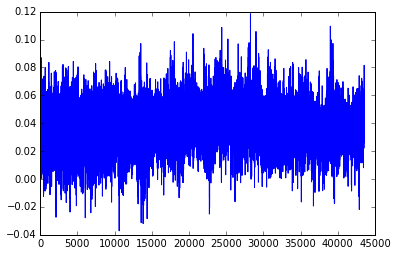

In [319]:
plt.plot(dif[~difm])

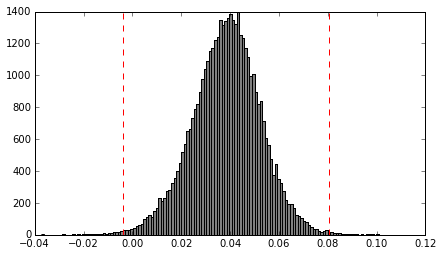

In [346]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
dif = np.array(bands[2])[:,0] - np.array(bands[2])[:,1]
difm = np.isnan(dif)
a = ax.hist(dif[~difm], bins = 150, color='gray')
ax.plot([mean-3*sigma, mean-3*sigma], [0, 1400], 'r--')
ax.plot([mean+3*sigma, mean+3*sigma], [0, 1400], 'r--')

In [322]:
sigma = np.nanstd(dif)
mean = np.nanmean(dif)
mean, sigma

(0.038353594946612155, 0.014106995745939297)

In [351]:
#three-sigma rule of thumb
Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


LinregressResult(slope=1.0164012131065558, intercept=-0.040317007446953879, rvalue=0.86141300130430287, pvalue=0.0, stderr=0.0028802323769371377)


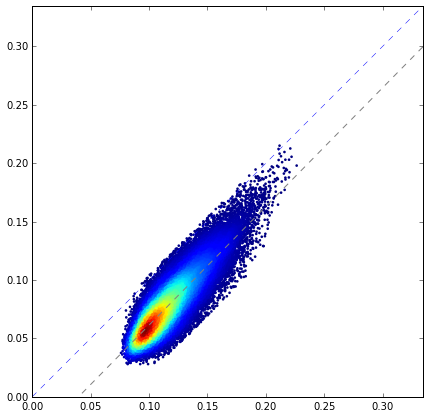

In [355]:
from scipy.stats import gaussian_kde
# x is brdf, y is the Sentinel
x,y = np.array(bands[2])[:,0], np.array(bands[2])[:,1]
y,x = x[inliers],y[inliers]


xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

Apply 3 sigma to cut off outliers so as to reo

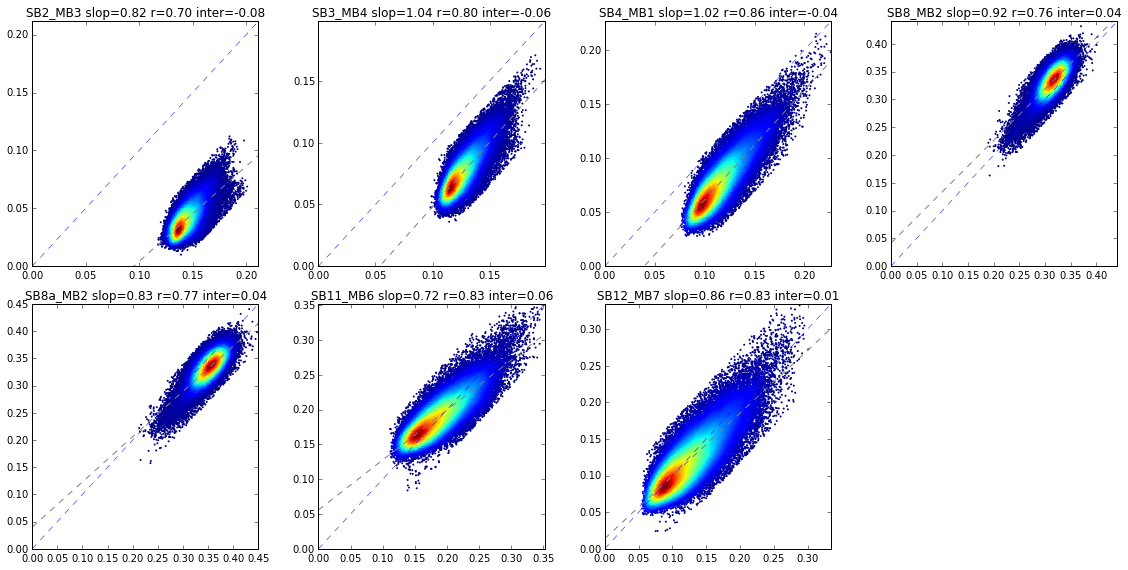

In [180]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
inters = []
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    inters.append(r.intercept)
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()

In [181]:
inters

[-0.077837880645250962,
 -0.056107121245713223,
 -0.040317007446953879,
 0.041367891992486139,
 0.03979030360865915,
 0.055810330701332622,
 0.013913835013377104]

However, actually, the modis pixel value covers an area that is near rectangle on the earth surface, and then projected on the sine grid which dose not means the area that it covers is an rectangle on the modis sine grid, but in reality not a rectangle. Thus, if we assume the actual earth surface is wgs84 grid, then when we transfer the modis pixel value into sentinel 2 grid, then the area that the value come from is a rectangle around the pixel. Though the Sentinel 2 has a mgrs map projection, bacically the pixels indexes are based on the lat and lon which does not induce a significant distotion like modis equal area.

In [2]:
b4_modis = parallel_rw_pkl(None, 'Rb4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'Rb2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'Rb3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'Rb8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'Rb8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'Rb11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'Rb12_modis', 'r')

In [3]:
bands = []
for j in [b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    
    data = []
    for i in j:
        data+=i
    bands.append(data)
names = ('b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis').split(',')

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


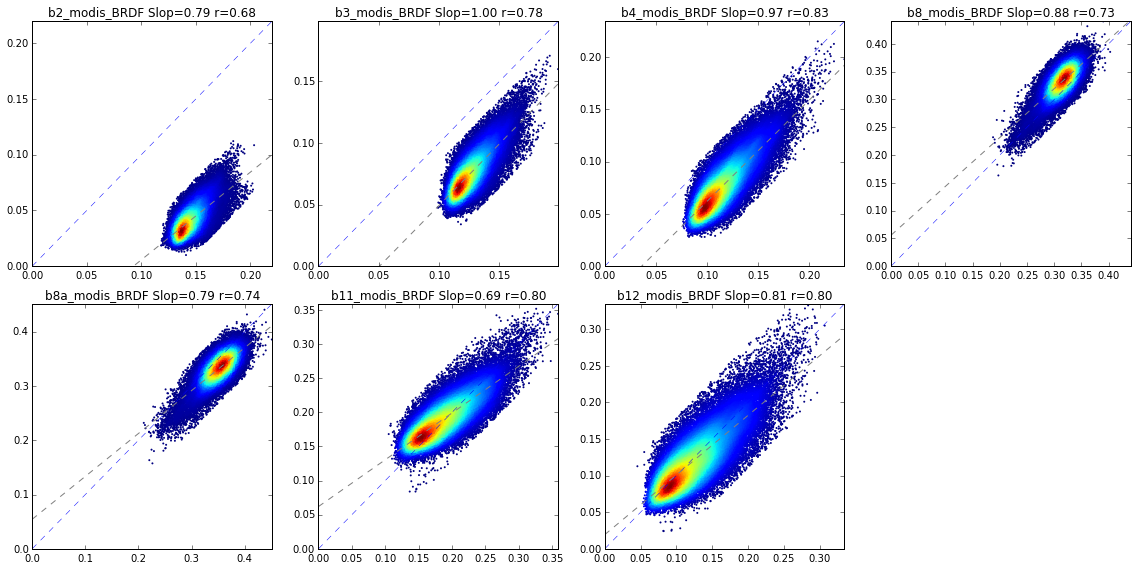

In [4]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s_BRDF'%names[i]+' Slop=%.2f'%r.slope+' r=%.2f'%r.rvalue)
plt.tight_layout()

Seems that the relationship becomes better with an improvement around 0.01 on the slop and 0.01 on the corelation between them. Thus, we can use the intercept of this regression to compensate an offset between the modis brdf value and sentinel reflectance and aplly the point spread function to compensate the displacement and other systematic erros, exclude the atomepheric effects, i.e. get a better regression between them. Here, the band4 is used firstly as an example.

In [215]:
a = np.arange(1200000).reshape((120,100,100))
year = 10
z = np.array([np.nanmean(a[12*i:12*i+12,:,:], axis=0) for i in range(year)])

In [7]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

<matplotlib.colorbar.Colorbar instance at 0x7f48089aa7e8>

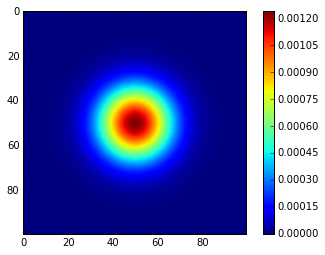

In [29]:
plt.imshow(gaussian(100,100, 8,8,45)/(gaussian(100,100, 8,8,45).sum()))
plt.colorbar()

A 2D gaussian with the option of choices on the x direction (east-west) and y direction (north- south) std, the window size for x and y direction, and the angle.

In [144]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl

fhead = 'data/50SMG20165100'

def shift(process):
    store = []
    for i, j in process:
        print i,j

        s1 = slice((i*1000),(i+1)*1000)
        s2 = slice((j*1000),(j+1)*1000)
        modis_cut = modis_sent[s1,s2]*0.001
        Stm_cut = Stm[s1,s2]

        sen_cut = Sent[s1,s2]
        ulist = np.unique(Stm_cut)
        
        
        for ii,u in enumerate(ulist):
            mask = (Stm_cut == u)
            if (mask.sum() >= 1800) and (mask.sum() < 4000):
                xmin = np.where(mask)[0].min()
                xmax = np.where(mask)[0].max()
                ymin = np.where(mask)[1].min()
                ymax = np.where(mask)[1].max()
                center0 = np.array([(xmax+xmin)/2, (ymax+ymin)/2])

                minx = center0[0] - 100
                maxx = center0[0] + 100
                miny = center0[1] - 100
                maxy = center0[1] + 100

                offset = -0.040317007446953879
                to_conv = sen_cut[max(0, minx): min(999, maxx), max(0, miny): min(999, maxy)]
                brdf = modis_cut[center0[0],center0[1]]
                
                
                if (to_conv.shape[0]>100) & (to_conv.shape[1]>100) & (brdf!=np.nan):
                    To_conv = to_conv + offset
                    Brdf = brdf
                    nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                    To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                    p = np.array([44, 22., 45.])
                    bound = np.array([(8.,200.),(8.,205.),(20.,187.)])
                    psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,\
                                                    args=(To_conv, Brdf),bounds=bound)

                    xstd, ystd, angle = psolve[0]
                    xwin,ywin = 100,100
                    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)
                    if gaus.sum() <= 0:
                        print 'invalid gauss: %s'%([xstd, ystd, angle])
                        pass
                    else:
                        kernel = gaus/(gaus.sum())    
                        s = signal.fftconvolve(To_conv, kernel, mode='valid')
                        dif = abs(s-brdf)
                        mindif = np.nanmin(dif)
                        # find out the shift in x and y direction, with the minimum distance accepted
                        cx,cy = np.array(s.shape)/2
                        sx,sy = np.where(dif == mindif)
                        shift = zip(sx-cx,sy-cy)
                        minsft = sorted(shift, key=lambda x: abs(x[1])+abs(x[0]))[0]

                        conved = to_conv[cx+minsft[0], cy+minsft[1]]
                        store.append([u, xstd, ystd, angle, conved, brdf, minsft[0], minsft[1]])

                        print 'solved one: ', ii, u, xstd, ystd, angle, conved, brdf, minsft
                else:
                    pass

            else:
                pass
    return store

def cost(p, To_conv = None, Brdf = None):

    xstd,ystd,angle = p
    #print p, (~np.isnan(To_conv)).all()

    xwin,ywin = 100,100
    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            

    
    ker = gaus/(gaus.sum())    
    s = signal.fftconvolve(To_conv, ker, mode='valid')
    dif = abs(s-Brdf)
    mindif = np.nanmin(dif)
    #print mindif
    return mindif



def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

In [ ]:
ind = pkl.load(open('pkls/gaus_trans.pkl','rb'))
inds = ind
data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')
Sent = readfile([4,],fhead)['B04']
cm = parallel_rw_pkl(None, '0510diacm', 'r')
Sent[cm] = np.nan
stm = parallel_rw_pkl(None, 'std_m', 'r')
print 'finshed reading data'
data[mask]=np.nan
modis_sent = np.array(data)
Stm = stm

In [ ]:
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
pros = np.array(np.array_split(patches, 16))

In [ ]:
par = partial(shift)
pool = multiprocessing.Pool(processes=16)
data = pool.map(par, pros)
pool.close()
pool.join()
parallel_rw_pkl(data, 'psfb4_modis', 'w')

print 'lol finishedb4!!!!!'

In [145]:
solved2 = shift([(0,0),])

0 0
solved one:  20 2326 153.327005784 8.0 38.9736745129 0.124195738335 0.129412683223 (-11, 10)
solved one:  22 4707 8.0 25.4136075475 70.1655126169 0.0875843995057 0.087584399506 (20, 0)
solved one:  23 4708 43.9643571526 22.0344543532 44.9997001633 0.0837653740587 0.0837653740595 (25, -4)
solved one:  24 4709 43.9999952108 22.0000168934 45.0000359962 0.0711789957073 0.0711795572016 (0, -2)
solved one:  25 4710 43.9998365034 21.9989285185 45.0002171334 0.0762971554659 0.0762971554603 (-12, 35)
solved one:  26 4711 44.0005681471 22.010375357 44.9958392829 0.0844390406838 0.0844390406836 (16, 30)
solved one:  27 4712 43.9260825796 22.5941706243 44.8756634268 0.104076836752 0.104076836751 (4, 50)
solved one:  28 4713 43.9996788162 21.9205398962 44.9926127398 0.123763888394 0.123763888389 (19, 32)
solved one:  29 4714 43.9993598103 22.0044313097 45.0001827218 0.115518037623 0.115518037622 (-21, -3)
solved one:  30 4715 43.9999831699 21.9994855137 44.9999492146 0.127430270423 0.1274302704

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in greater


In [19]:
solved = np.array(solved, dtype=object).T

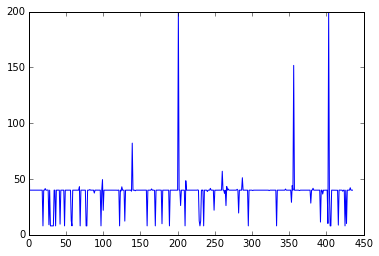

In [32]:
plt.plot(solved[1])

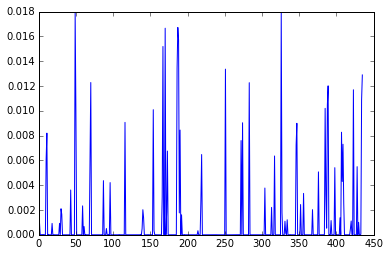

In [29]:
plt.plot(abs(solved[4]-solved[5]))

In [44]:
unziped = zip(*solved[6])

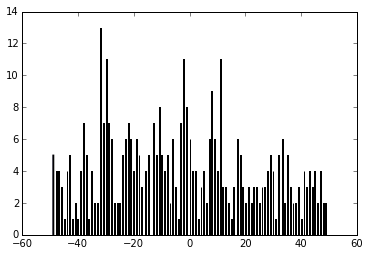

In [62]:
unziped = np.array(unziped)
x = plt.hist((unziped[0])[(unziped[0]<50)&(unziped[0]>-50)], bins = 300)

In [78]:
(unziped[0])[(unziped[0]<50)&(unziped[0]>-50)].mean()

-3.1896551724137931

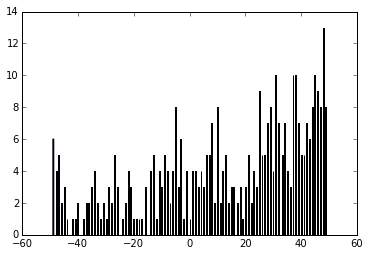

In [63]:
x = plt.hist((unziped[1])[(unziped[1]<50)&(unziped[1]>-50)], bins = 300)

In [77]:
(unziped[1])[(unziped[1]<50)&(unziped[1]>-50)].mean()

12.534177215189873

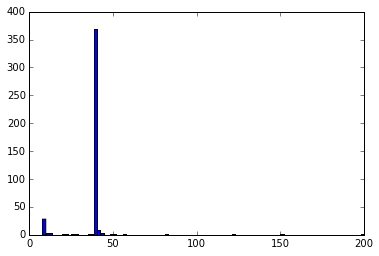

In [60]:
x = plt.hist(solved[1], bins = 100)

In [80]:
solved[1].mean(), solved[2].mean()

(38.586757629659189, 79.637725506717814)

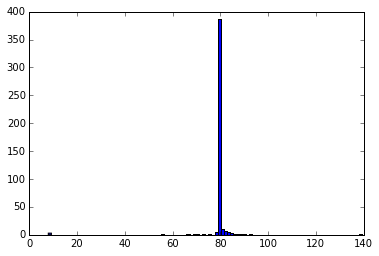

In [59]:
x = plt.hist(solved[2], bins = 100)

44.6820079013


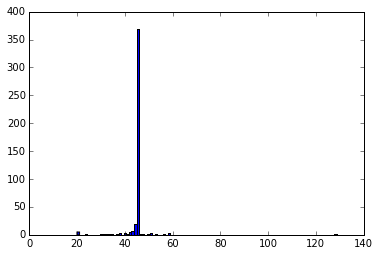

In [130]:
x = plt.hist(solved[3], bins = 100)
print solved[3].mean()

LinregressResult(slope=1.0479077505838095, intercept=-0.0043117754924833773, rvalue=0.99054164223950358, pvalue=0.0, stderr=0.0069678525551253858)


/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


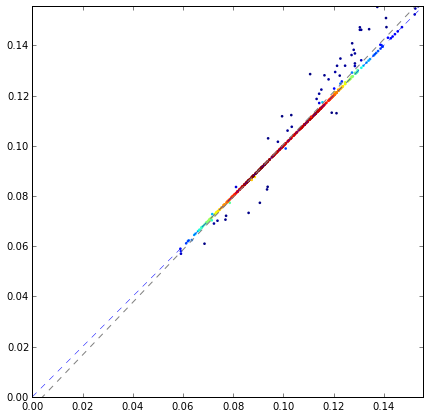

In [39]:
from scipy.stats import gaussian_kde
# x is brdf, y is the Sentinel
#x,y = np.array(bands[2])[:,0], np.array(bands[2])[:,1]
y,x = np.array(solved[4]).astype('float'), np.array(solved[5]).astype('float')

maxval = np.max(np.max(y),np.max(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

LinregressResult(slope=1.0231594710663936, intercept=-0.0021905328597013884, rvalue=0.99653154183507575, pvalue=0.0, stderr=0.0041012262908437114)


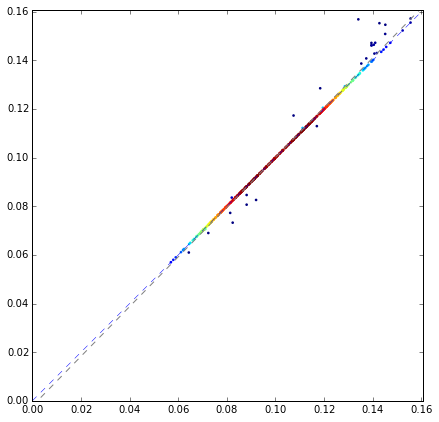

In [81]:
from scipy.stats import gaussian_kde
# x is brdf, y is the Sentinel
#x,y = np.array(bands[2])[:,0], np.array(bands[2])[:,1]
y,x = solved2[4], solved2[5]

maxval = np.max(np.max(y),np.max(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

In [146]:
solved2 = np.array(solved2).T

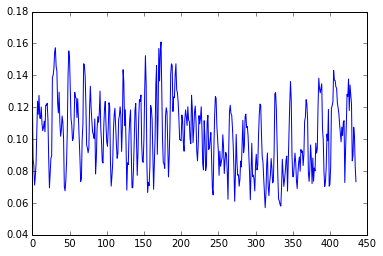

In [147]:
plt.plot(solved2[5])

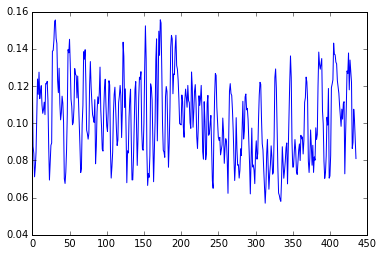

In [148]:
plt.plot(solved2[4])

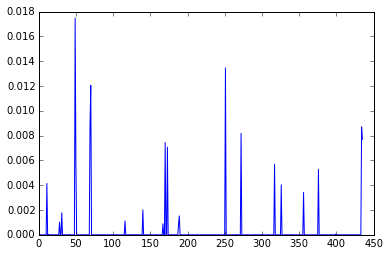

In [149]:
plt.plot(abs(solved2[5]-solved2[4]))

41.8725426787


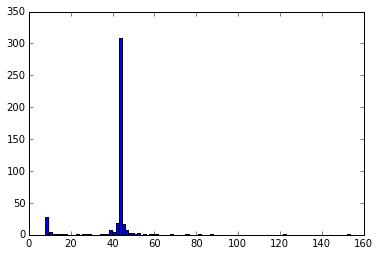

In [150]:
x = plt.hist(solved2[1], bins = 100)
print solved2[1].mean()

24.7544561511


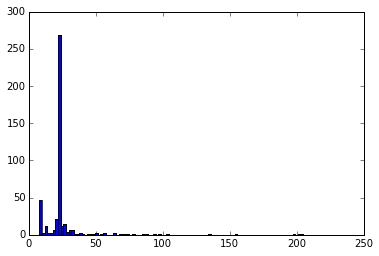

In [151]:
x = plt.hist(solved2[2], bins = 100)
print solved2[2].mean()

46.6626096076


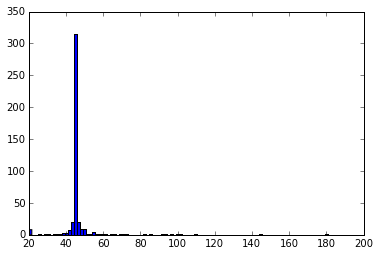

In [152]:
x = plt.hist(solved2[3], bins = 100)
print solved2[3].mean()

-3.0382775119617227

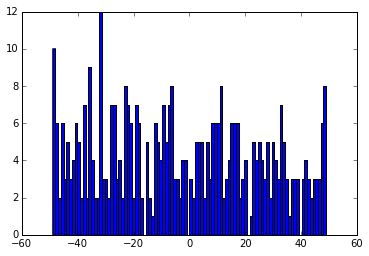

In [158]:
x = plt.hist(solved2[6][(solved2[6]<50)&(solved2[6]>-50)], bins = 100)
solved2[6][(solved2[6]<50)&(solved2[6]>-50)].mean()

10.5945273632


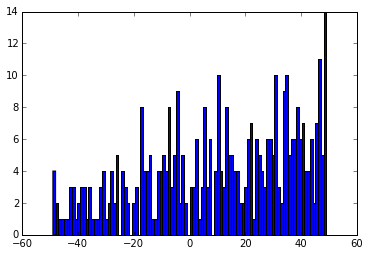

In [159]:
x = plt.hist(solved2[7][(solved2[7]<50)&(solved2[7]>-50)], bins = 100)
print solved2[7][(solved2[7]<50)&(solved2[7]>-50)].mean()

In [164]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl

fhead = 'data/50SMG20165100'

def applied(process):
    store = []
    for i, j in process:
        print i,j

        s1 = slice((i*1000),(i+1)*1000)
        s2 = slice((j*1000),(j+1)*1000)
        modis_cut = modis_sent[s1,s2]*0.001
        Stm_cut = Stm[s1,s2]

        sen_cut = Sent[s1,s2]
        ulist = np.unique(Stm_cut)
        
        
        for ii,u in enumerate(ulist):
            mask = (Stm_cut == u)
            if (mask.sum() >= 1800) and (mask.sum() < 4000):
                xmin = np.where(mask)[0].min()
                xmax = np.where(mask)[0].max()
                ymin = np.where(mask)[1].min()
                ymax = np.where(mask)[1].max()
                center0 = np.array([(xmax+xmin)/2, (ymax+ymin)/2])
                
                xs,ys = -3.0382775119617227, 10.5945273632

                minx = center0[0]+xs - 50
                maxx = center0[0]+xs + 50
                miny = center0[1]+ys - 50
                maxy = center0[1]+ys + 50

                #offset = -0.040317007446953879
                to_conv = sen_cut[max(0, minx): min(999, maxx), max(0, miny): min(999, maxy)]
                brdf = modis_cut[center0[0],center0[1]]
                
                
                if (to_conv.shape[0]>=100) & (to_conv.shape[1]>=100) & (brdf!=np.nan):
                    To_conv = to_conv
                    Brdf = brdf
                    nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                    To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                   
                    xstd, ystd, angle = 41.8725426787, 24.7544561511, 46.6626096076
                    xwin,ywin = 100,100
                    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)
                    if gaus.sum() <= 0:
                        print 'invalid gauss: %s'%([xstd, ystd, angle])
                        pass
                    else:
                        kernel = gaus/(gaus.sum())    
                        s = signal.fftconvolve(to_conv, kernel, mode='valid')
                        
                        store.append([s[0][0], brdf])
                else:
                    pass

            else:
                pass
    return store

In [165]:
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
pros = np.array(np.array_split(patches, 16))
par = partial(applied)
pool = multiprocessing.Pool(processes=16)
data = pool.map(par, pros)
pool.close()
pool.join()
parallel_rw_pkl(data, 'psfb4_modis', 'w')

print 'lol finishedb4!!!!!'

Length of data: 16
Length of data: 16
0 0
0 7
2 1
1 4
2 8
3 4
4 6
5 2
4 0
5 8
6 4
7 0
7 6
8 2
8 8
9 4
0021234545677889 1
 8
 2
 5
 9
 5
 7
 3
 1
 9
 5
 1
 7
 3
 9
 5
0021334546677899 2
 9
 3
 6
 0
 6
 8
 4
 2
 0
 6
 2
 8
 4
 0
 6
0121334546677899 3
 0
 4
 7
 1
 7
 9
 5
 3
 1
 7
 3
 9
 5
 1
 7
0121335546678899 4
 1
 5
 8
 2
 8
 0
 6
 4
 2
 8
 4
 0
 6
 2
 8
0121335546678899 5
 2
 6
 9
 3
 9
 1
 7
 5
 3
 9
 5
 1
 7
 3
 9
0122 6
 3
 7
 0


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site

lol finishedb4!!!!!


In [162]:
aped = np.array(aped).T

In [172]:
solves = []
for i in data:
    solves+=i
solves = np.array(solves).T

LinregressResult(slope=0.9885904291338401, intercept=-0.036977282377779405, rvalue=0.8505543952573057, pvalue=0.0, stderr=0.0031548797772415521)


/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:324: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = np.fmax.reduce(a, axis=axis, out=out, keepdims=keepdims)


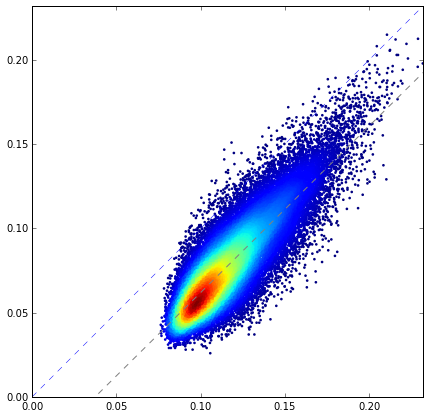

In [174]:
from scipy.stats import gaussian_kde
# x is brdf, y is the Sentinel
#x,y = np.array(bands[2])[:,0], np.array(bands[2])[:,1]
nanm = np.isnan(solves[0]) | np.isnan(solves[1])
y,x = solves[0][~nanm], solves[1][~nanm]

maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

LinregressResult(slope=0.99158172510062337, intercept=-0.037413108405861512, rvalue=0.85792678407164336, pvalue=0.0, stderr=0.0030734866442185191)


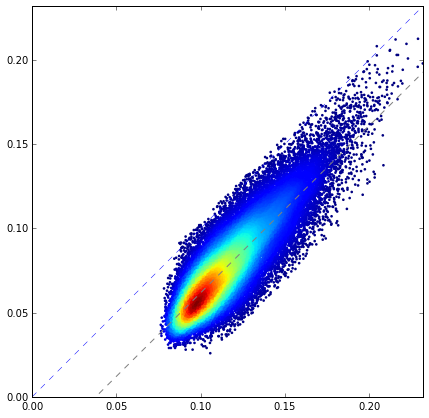

In [175]:
nanm = np.isnan(solves[0]) | np.isnan(solves[1])
y,x = solves[0][~nanm], solves[1][~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

Apply this parameters to the other 6 bands:

In [ ]:
b4_modis = parallel_rw_pkl(None, 'psfb4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'psfb2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'psfb3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'psfb8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'psfb8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'psfb11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'psf12_modis', 'r')

In [230]:
bands = []
for j in [b2_modis,b3_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    
    data = []
    for i in j:
        data+=i
    bands.append(data)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')

In [234]:
bands.insert(2, solves.T)

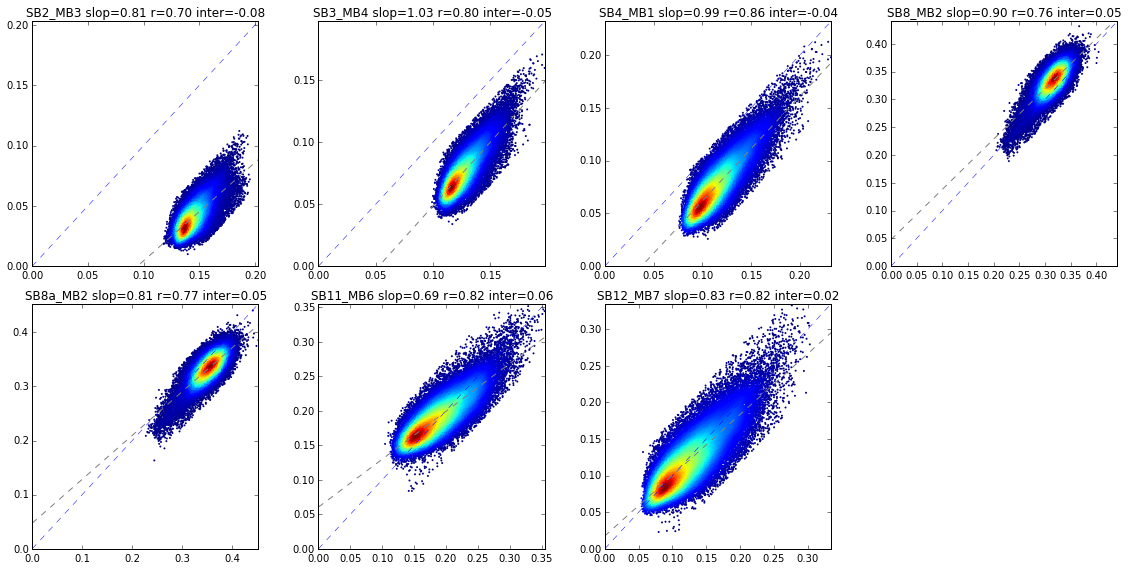

In [237]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()

However, the results shows no improvement and even worse than then previous average, maybe it means the need to get the psf for each band instead of using only one for different bands, as for sentinel 2 each band has a separate sampling parameters so the misplacement and point spread function should be tured for each band.

###  gaussian point spread function

In [ ]:
#read in some sentinel data band4 for this 
fhead = 'data/50SMG20165100'
Sent = readfile([4,],fhead)['B04']

In [16]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

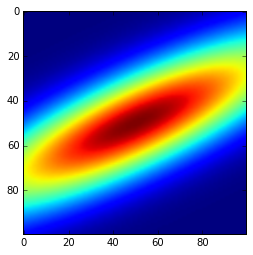

In [17]:
gaus = gaussian(100,100, 10,40,25)
plt.imshow(gaus)

<matplotlib.colorbar.Colorbar instance at 0x7f362ebef830>

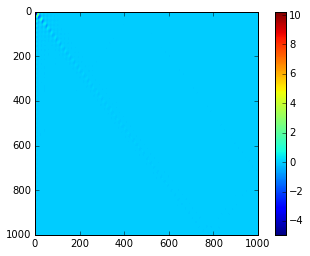

In [86]:
dct_g = dct(dct(geo_gaus, axis = 0, type=2, norm = 'ortho'), axis=1, type=2,norm = 'ortho')
plt.imshow(dct_g)
plt.colorbar()

In [21]:
# this is the real pixels that from the modis brdf products
c_pixels = np.array(parallel_rw_pkl(None, 'c_pixels', 'r')).T

In [ ]:
mask = parallel_rw_pkl(None, '0510diacm', 'r')

<matplotlib.colorbar.Colorbar instance at 0x7f367fdbca28>

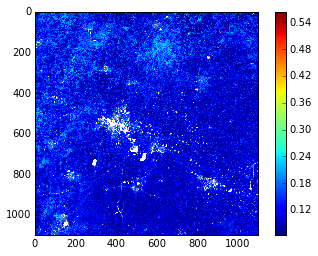

In [25]:
plt.imshow(ma.array(Sent, mask=mask)[::10,::10])
plt.colorbar()

In [47]:
data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')
modis_sent = data[:1000,:1000]
modis_sentm = mask[:1000,:1000]

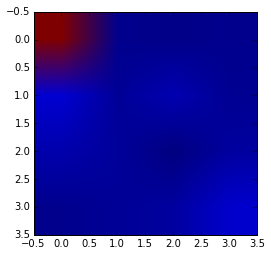

In [52]:
dct_b4 = dct(dct(band4, axis = 0, type=2, norm = 'ortho'), axis=1, type=2, norm = 'ortho')
plt.imshow(dct_b4[:4,:4])

<matplotlib.colorbar.Colorbar instance at 0x7f36302eff38>

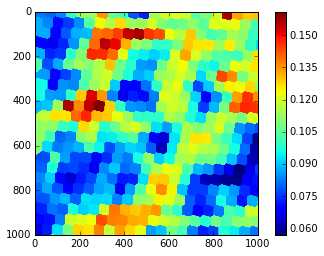

In [48]:
plt.imshow(ma.array(modis_sent*0.001, mask=modis_sentm))
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f3660c967e8>

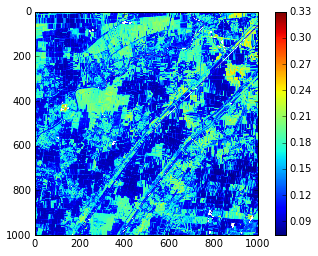

In [27]:
# do it on a small patch
band4 = Sent[:1000,:1000]
band4m = mask[:1000,:1000]
plt.imshow(ma.array(band4, mask = band4m))
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f362eab5d40>

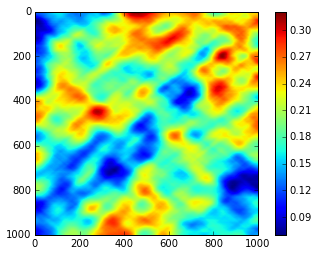

In [87]:
conved = idct(idct((dct_b4*dct_g), axis=1, type = 1,),axis=0,type = 1)
plt.imshow(conved*(1./(4*1000.)))
plt.colorbar()

In [88]:
mx = c_pixels[0][(c_pixels[0]<1000)&(c_pixels[1]<1000)]
my = c_pixels[1][(c_pixels[0]<1000)&(c_pixels[1]<1000)]
a = conved[mx, my]
b = modis_sent[mx, my]
a = a[~(np.isnan(a)|np.isnan(b))]*0.0001
b = b[~(np.isnan(a)|np.isnan(b))]*(1/(4*1000.))
r = scipy.stats.linregress(a,b)
print r

LinregressResult(slope=0.12434588952532873, intercept=0.016035930607839179, rvalue=0.42012370620302381, pvalue=1.079713420712303e-21, stderr=0.012362719397088275)


######  A sine gaussian

In [94]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5

    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
    xgaus = []
    for k in np.arange(winx):
        f = np.exp(-0.5*(k*np.pi*xstd/winx)**2)
        xgaus.append(f)

    ygaus = []
    for k in np.arange(winy):
        f = np.exp(-0.5*(k*np.pi*xstd/winy)**2)
        ygaus.append(f)

    gaus  = np.outer(xgaus, ygaus)    
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    return r_gaus

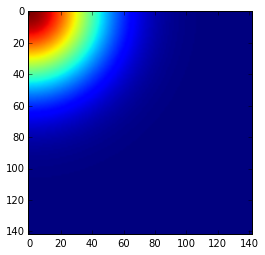

In [120]:
gaus = gaussian(100,100, 1,2,0)
plt.imshow(gaus)

In [121]:
pad_g = np.zeros((1000,1000))
pad_g[ : gaus.shape[0], : gaus.shape[1]] = gaus

<matplotlib.colorbar.Colorbar instance at 0x7f368141c638>

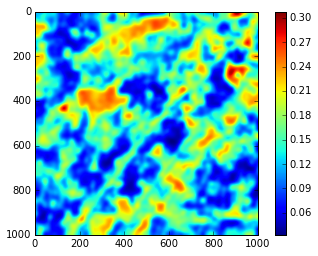

In [123]:
conved = idct(idct((pad_g*dct_b4), axis=1, type = 2,),axis=0,type = 2)
plt.imshow(conved/1000.)
plt.colorbar()

But, how about we have a different angle with dct?

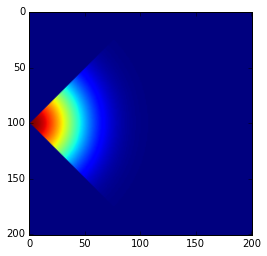

In [124]:
gaus = gaussian(100,100, 1,2,45)
plt.imshow(gaus)

<matplotlib.colorbar.Colorbar instance at 0x7f368121bea8>

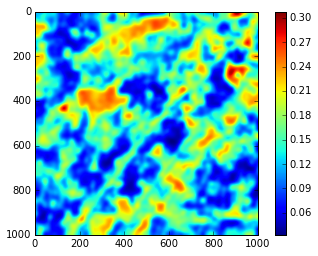

In [125]:
conved = idct(idct((pad_g*dct_b4), axis=1, type = 2,),axis=0,type = 2)
plt.imshow(conved/1000.)
plt.colorbar()

It fails.... so maybe try separate gaussian to x direction then y direction and times them and then times the data...

In [211]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

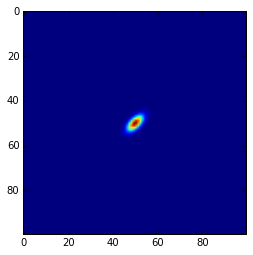

In [212]:
gaus = gaussian(100,100, 1,2,45)
plt.imshow(gaus)

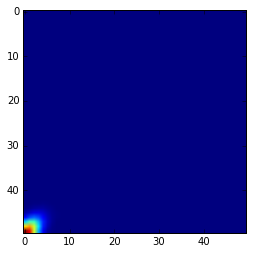

In [181]:
plt.imshow(gaus[:50,50:])

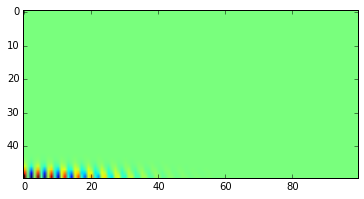

In [182]:
ydct = dct(gaus[:50,:], type=1, axis = 1)
plt.imshow(ydct)

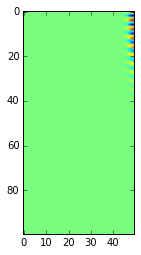

In [183]:
xdct = dct(gaus[:,:50], type=1, axis = 0)
plt.imshow(xdct)

In [184]:
dct1 = np.zeros((1000,1000))
dct1[:50,:100] = ydct
dct2 = np.zeros((1000,1000))
dct2[:100,:50] = xdct
dctg = dct1*dct2

<matplotlib.colorbar.Colorbar instance at 0x7f362aaffea8>

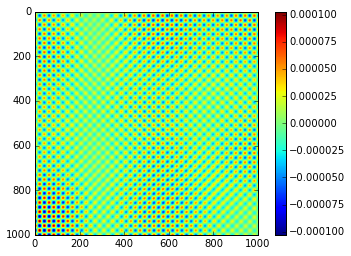

In [185]:
conved = idct(idct((dctg*dct_b4), axis=1, type = 2,),axis=0,type = 2)
plt.imshow(conved)
plt.colorbar()

In [186]:
xgaus = []
winx = 100
winy = 100
xstd=1
ystd = 2
for k in np.arange(winx):
    f = np.exp(-0.5*(k*np.pi*xstd/winx)**2)
    xgaus.append(f)

ygaus = []
for k in np.arange(winy):
    f = np.exp(-0.5*(k*np.pi*xstd/winy)**2)
    ygaus.append(f)

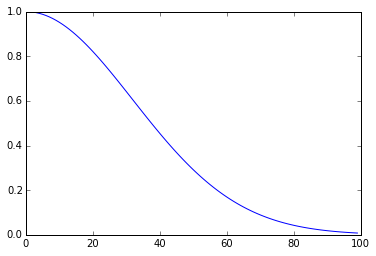

In [189]:
plt.plot(ygaus)

So, here I simply use the fast furious transformation (fft) with the border symmetrically dialated.

In [209]:
def syn_dilation(shape, dia, data):
    shape = 1000
    dia = 100
    hdia = dia/2
    # for symetric dialation of the patche to avoid the border effects
    dia = np.zeros(np.array(data.shape)+dia)
    dia[:hdia,:hdia] = data[:hdia,:hdia][::-1,::-1]
    dia[:hdia,hdia:shape+hdia] = data[:hdia,::][::-1, ::]
    dia[hdia:shape+hdia, :hdia] = data[::,:hdia][::,::-1]
    dia[shape+hdia:, :hdia] = data[-hdia:,:hdia][::-1,::-1]
    dia[shape+hdia:,hdia:shape+hdia] = data[-hdia:, ::][::-1,::]
    dia[shape+hdia:,shape+hdia:] = data[-hdia:, -hdia:][::-1,::-1]
    dia[hdia:shape+hdia, shape+hdia:] = data[::, -hdia:][::,::-1]
    dia[:hdia,shape+hdia:] = data[:hdia,-hdia:][::-1,::-1]
    dia[hdia:shape+hdia, hdia:shape+hdia] = data
    return dia

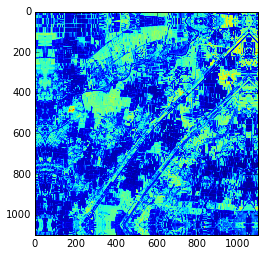

In [210]:
dia_b4 = syn_dilation(1000, 100, band4)
plt.imshow(dia_b4)

In [ ]:
gaus = gaussian(100,100, 10,20, 0)
s = signal.fftconvolve(dia_b4, gaus/gaus.sum(), mode='same')[50:1050,50:1050]

<matplotlib.colorbar.Colorbar instance at 0x7f3629a437e8>

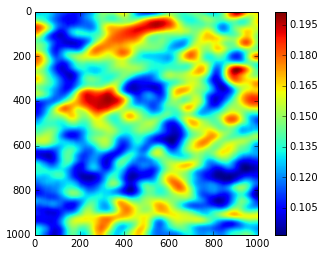

In [224]:
plt.imshow(s)
plt.colorbar()

In [239]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus


def conv(p, sen = None, ms = None, c_pixels = None):
    
    xstd,ystd,angle, sx, sy = p
    print p
    
    xwin,ywin = 100,100
    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            

    if gaus.sum() <= 0:
        print 'invalid gauss: %s'%([xstd, ystd, angle])
        pass
    else:
        ker = gaus/(gaus.sum())
    
    # for symetric dialation of the patche to avoid the border effects
    shape = 1000
    dia = 100
    hdia = dia/2
    to_conv = syn_dilation(shape, dia, sen)
    
    s = signal.fftconvolve(to_conv, ker, mode='same')[hdia:shape+hdia,hdia:shape+hdia]
    m = ms*0.001
    
    mx = c_pixels[0][(c_pixels[0]<1000)&(c_pixels[1]<1000)]
    my = c_pixels[1][(c_pixels[0]<1000)&(c_pixels[1]<1000)]
        
    vm = m[mx, my]
    vs = s[mx, my]
    
    vm = vm[~vm.mask]; vs = vs[~vm.mask]    
    r = scipy.stats.linregress(vs,vm)
    cost = 1-r.rvalue
    print cost
    return cost

def syn_dilation(shape, dia, data):
    shape = 1000
    dia = 100
    hdia = dia/2
    # for symetric dialation of the patche to avoid the border effects
    dia = np.zeros(np.array(data.shape)+dia)
    dia[:hdia,:hdia] = data[:hdia,:hdia][::-1,::-1]
    dia[:hdia,hdia:shape+hdia] = data[:hdia,::][::-1, ::]
    dia[hdia:shape+hdia, :hdia] = data[::,:hdia][::,::-1]
    dia[shape+hdia:, :hdia] = data[-hdia:,:hdia][::-1,::-1]
    dia[shape+hdia:,hdia:shape+hdia] = data[-hdia:, ::][::-1,::]
    dia[shape+hdia:,shape+hdia:] = data[-hdia:, -hdia:][::-1,::-1]
    dia[hdia:shape+hdia, shape+hdia:] = data[::, -hdia:][::,::-1]
    dia[:hdia,shape+hdia:] = data[:hdia,-hdia:][::-1,::-1]
    dia[hdia:shape+hdia, hdia:shape+hdia] = data
    return dia

In [264]:
c_pixels = np.array(parallel_rw_pkl(None, 'c_pixels', 'r')).T
p = np.array([144.,25., 119., 0, 0])
bound = np.array([(8.,200.),(8.,205.),(62.,187.),(-50.,50.),(-50.,50.)])
mb4 = ma.array(band4, mask = band4m)
mms = ma.array(modis_sent, mask = modis_sentm)
psolve = optimize.fmin_l_bfgs_b(conv,p,approx_grad=True,iprint=-1,\
                                args=(mb4, mms,c_pixels),bounds=bound)

[ 144.   25.  119.    0.    0.]
(1000, 1000)
0.288414338044
[ 144.00000001   25.          119.            0.            0.        ]
(1000, 1000)
0.288414338044
[ 144.           25.00000001  119.            0.            0.        ]
(1000, 1000)
0.288414338044
[ 144.           25.          119.00000001    0.            0.        ]
(1000, 1000)
0.288414338045
[  1.44000000e+02   2.50000000e+01   1.19000000e+02   1.00000000e-08
   0.00000000e+00]
(1000, 1000)
0.288414338044
[  1.44000000e+02   2.50000000e+01   1.19000000e+02   0.00000000e+00
   1.00000000e-08]
(1000, 1000)
0.288414338044
[ 144.00001056   25.00003574  118.99996363    0.            0.        ]
(1000, 1000)
0.288414335332
[ 144.00001057   25.00003574  118.99996363    0.            0.        ]
(1000, 1000)
0.288414335332
[ 144.00001056   25.00003575  118.99996363    0.            0.        ]
(1000, 1000)
0.288414335332
[ 144.00001056   25.00003574  118.99996364    0.            0.        ]
(1000, 1000)
0.288414335333
[  1.440

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


psolve1
(array([ 144.        ,   25.78471154,  119.63576523,    0.        ,    0.        ]),
 0.28805609804127452,
 {'funcalls': 684,
  'grad': array([ -1.00475184e-05,  -5.11812814e-06,   1.33226763e-07,
           0.00000000e+00,   0.00000000e+00]),
  'nit': 23,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [265]:
psolve

(array([ 164.93633514,   25.87525214,  119.87927791,    0.        ,    0.        ]),
 0.28788433083220721,
 {'funcalls': 504,
  'grad': array([ -6.67244038e-06,  -3.01980663e-06,   3.94129174e-06,
           0.00000000e+00,   0.00000000e+00]),
  'nit': 11,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<matplotlib.colorbar.Colorbar instance at 0x7f36293aa248>

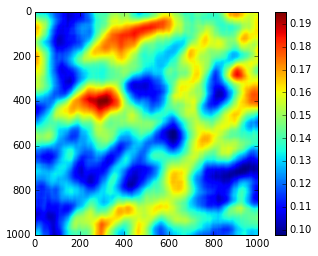

In [266]:
gaus = gaussian(100,100, 164.93633514, 25.87525214, 119.87927791)
s = signal.fftconvolve(dia_b4, gaus/gaus.sum(), mode='same')[50:1050,50:1050]
plt.imshow(s)
plt.colorbar()

In [268]:
m = mms*0.001
mx = c_pixels[0][(c_pixels[0]<1000)&(c_pixels[1]<1000)]
my = c_pixels[1][(c_pixels[0]<1000)&(c_pixels[1]<1000)]

s = ma.array(s, mask = mb4.mask)

vm = m[mx, my]
vs = s[mx, my]

mvm = vm[~(vm.mask|vs.mask)]; 
mvs = vs[~(vm.mask|vs.mask)]    
r = scipy.stats.linregress(mvs,mvm)

LinregressResult(slope=0.83087791025460211, intercept=-0.012514060438869212, rvalue=0.71507133618344465, pvalue=4.2632752223250051e-75, stderr=0.03746692745826765)


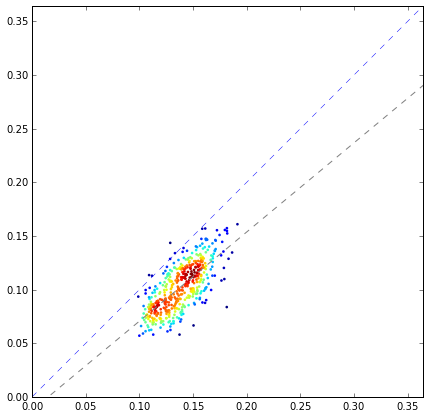

In [272]:
from scipy.stats import gaussian_kde
# x is brdf, y is the Sentinel
x,y = mvm,mvs


xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

Apply it to the whole image.

In [ ]:
data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')

ms = ma.array(data, mask = mask)[:10000,:10000]

In [ ]:
mask = parallel_rw_pkl(None, '0510diacm', 'r')

sen = ma.array(Sent, mask = mask)[:10000,:10000]

In [294]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus


def conv(p, sen = None, ms = None, c_pixels = None):
    
    xstd,ystd,angle, sx, sy = p
    print p
    
    xwin,ywin = 100,100
    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            

    if gaus.sum() <= 0:
        print 'invalid gauss: %s'%([xstd, ystd, angle])
        pass
    else:
        ker = gaus/(gaus.sum())
    
    # for symetric dialation of the patche to avoid the border effects
    shape = sen.shape[0]
    dia = 200
    hdia = dia/2
    to_conv = syn_dilation(shape, dia, sen)
    
    s = signal.fftconvolve(to_conv, ker, mode='same')[hdia:shape+hdia,hdia:shape+hdia]
    m = ms*0.001
    
    mx = c_pixels[0][(c_pixels[0]<shape)&(c_pixels[1]<shape)]
    my = c_pixels[1][(c_pixels[0]<shape)&(c_pixels[1]<shape)]
    
    s = ma.array(s, mask = sen.mask)

    vm = m[mx, my]
    vs = s[mx, my]

    mvm = vm[~(vm.mask|vs.mask)]; 
    mvs = vs[~(vm.mask|vs.mask)]    
    r = scipy.stats.linregress(mvs,mvm)
    
    cost = 1-r.rvalue
    print cost
    return cost

def syn_dilation(shape, dia, data):
    hdia = dia/2
    # for symetric dialation of the patche to avoid the border effects
    dias = np.zeros(np.array(data.shape)+dia)
    dias[:hdia,:hdia] = data[:hdia,:hdia][::-1,::-1]
    dias[:hdia,hdia:shape+hdia] = data[:hdia,::][::-1, ::]
    dias[hdia:shape+hdia, :hdia] = data[::,:hdia][::,::-1]
    dias[shape+hdia:, :hdia] = data[-hdia:,:hdia][::-1,::-1]
    dias[shape+hdia:,hdia:shape+hdia] = data[-hdia:, ::][::-1,::]
    dias[shape+hdia:,shape+hdia:] = data[-hdia:, -hdia:][::-1,::-1]
    dias[hdia:shape+hdia, shape+hdia:] = data[::, -hdia:][::,::-1]
    dias[:hdia,shape+hdia:] = data[:hdia,-hdia:][::-1,::-1]
    dias[hdia:shape+hdia, hdia:shape+hdia] = data
    return dias

In [295]:
p = np.array([8.,24., 89., 0, 0])
bound = np.array([(8.,200.),(8.,205.),(62.,187.),(-50.,50.),(-50.,50.)])
psolve = optimize.fmin_l_bfgs_b(conv,p,approx_grad=True,iprint=-1,\
                                args=(sen, ms,c_pixels),bounds=bound)

[  8.  24.  89.   0.   0.]
0.93255930927
[  8.00000001  24.          89.           0.           0.        ]
0.932559309263
[  8.          24.00000001  89.           0.           0.        ]
0.932559309267
[  8.          24.          89.00000001   0.           0.        ]
0.93255930927
[  8.00000000e+00   2.40000000e+01   8.90000000e+01   1.00000000e-08
   0.00000000e+00]
0.93255930927
[  8.00000000e+00   2.40000000e+01   8.90000000e+01   0.00000000e+00
   1.00000000e-08]
0.93255930927
[  8.0006213   24.00027808  89.00001579   0.           0.        ]
0.932558845708
[  8.00062131  24.00027808  89.00001579   0.           0.        ]
0.932558845702
[  8.0006213   24.00027809  89.00001579   0.           0.        ]
0.932558845705
[  8.0006213   24.00027808  89.0000158    0.           0.        ]
0.932558845708
[  8.00062130e+00   2.40002781e+01   8.90000158e+01   1.00000000e-08
   0.00000000e+00]
0.932558845708
[  8.00062130e+00   2.40002781e+01   8.90000158e+01   0.00000000e+00
   1.00000

In [21]:
from scipy import signal
import numpy as np
for i in np.linspace(1, 100, 801):
    a = signal.gaussian(100,i)
    middle = a[25:75]
    if abs(middle.sum()/a.sum() - 0.75) <0.001:
        print i
    

22.65625


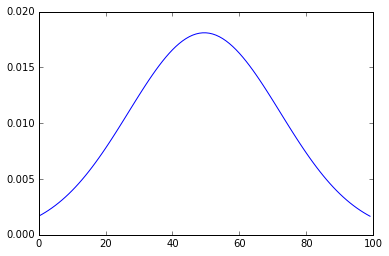

In [30]:
x = signal.gaussian(100,22.65625)
plt.plot(x/x.sum())

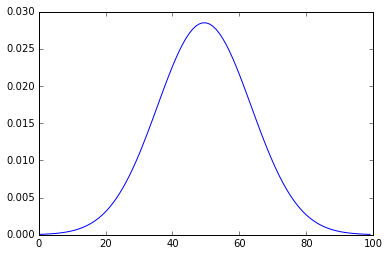

In [48]:
y = signal.gaussian(100,14)
plt.plot(y/y.sum())